# 量子計算の基礎

In [ ]:
!pip install --upgrade qiskit
!pip install --upgrade qiskit-ibm-runtime

In [52]:
import numpy as np
from qiskit import *

In [53]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator, BackendSamplerV2 as BackendSampler
from qiskit.providers.basic_provider import BasicProvider 
from qiskit.primitives import StatevectorEstimator, StatevectorSampler

ここでは主にqiskitを用いて量子多体系の計算を行う方法について学ぶ

目標  
* ゲート型/回路型の量子計算の仕組みを理解する
* 簡単な例を実行できるようになる (例が偏っているのをご容赦いただきたい)


## ゲート型/回路型の量子計算機の仕組み

ゲート型量子計算機は量子ビット(qubit), 量子ゲート, 測定から成り, 一連の手続きをまとめると以下の通りである

* 量子ビットを用意する. 初期状態は$|0\cdots0\rangle$であることが多い

* 量子ゲート (ユニタリ行列) $U$を作用させて, 初期状態から調べたい量子多体系の状態を作る

  $|\psi\rangle=U|0\cdots0\rangle$

* 測定する

* これらの一連の操作を表すものが量子回路図である

* 量子回路図に描かれた演算を何度も何度も繰り返し実行することになる. 1回1回の実行のことをショットという.


* 測定直前の状態が$|\psi\rangle=U|0\cdots0\rangle=\sum_{i_1,\ldots,i_N}\psi_{i_1,\ldots,i_N}|i_1\cdots i_N\rangle$であるとする

  一回測定(射影測定)を行う度に, 確率$|\psi_{i_1,\ldots,i_N}|^2$に応じて, $|i_1\cdots i_N\rangle$のいづれかの状態が一つ観測される

  射影測定が行われる基底を計算基底という. $(i_1,\cdots,i_N)$をビットストリングという.

  測定する度にビットストリングが得られ,何度も繰り返すことで, $\frac{N_{i_1,\ldots,i_N}}{N}$として確率分布$|\psi_{i_1,\ldots,i_N}|^2$が推測できる

  $N$はショットの回数. $N_{i_1,\ldots,i_N}$はビットストリング$(i_1,\cdots,i_N)$が得られた回数

* 確率分布から物理量の期待値を計算する

* Mid-Circuit Measurement and Feed-Forward

  量子回路の途中で一部の量子ビットを測定し, 得られた結果に応じて量子ゲート作用させることも可能



### ユニバーサル量子ゲートセット

古典計算の場合はパウリ行列のテンソル積を用意すれば, 任意のハミルトニアンで表される物理系の問題を解くことができた

量子計算の場合はどのような量子ゲートが用意できれば, 任意のハミルトニアンで表される物理系の問題を解くことができるだろうか？

これに関してユニバーサル量子ゲートセット{CNOT,H,T}という組みを用意できれば任意の多体量子ゲートを{CNOT,H,T}の組み合わせを用いて実装できることが知られている

ここで, $T=\begin{pmatrix} 1 & 0 \\ 0 & e^{{\rm i}\frac{\pi}{4}}\end{pmatrix}$はT gateという

CNOTは次の2量子ビット演算子である: $\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1  & 0 \end{pmatrix}$


参考文献: https://quantphys.org/wp/keisukefujii/misc/%E9%9B%86%E4%B8%AD%E8%AC%9B%E7%BE%A9%EF%BC%8F%E9%87%8F%E5%AD%90%E3%82%B3%E3%83%B3%E3%83%94%E3%83%A5%E3%83%BC%E3%82%BF%E6%A6%82%E8%AB%96/

### よく使う量子ゲート

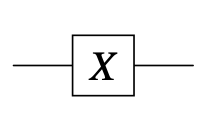

$X=\begin{pmatrix} 0 & 1 \\ 1 & 0\end{pmatrix}$

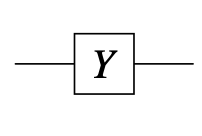

$Y=\begin{pmatrix} 0 & -{\rm i} \\ {\rm i} & 0\end{pmatrix}$

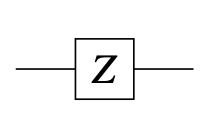

$Z=\begin{pmatrix} 1 & 0 \\ 0 & -1\end{pmatrix}$

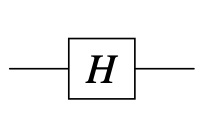

$H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1\end{pmatrix}$

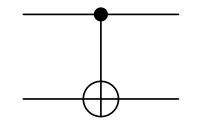

CX=$\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1  & 0 \end{pmatrix}$

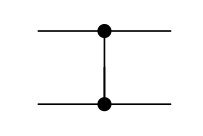

CZ=$\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0  & -1 \end{pmatrix}$

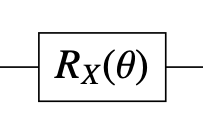

$R_X(\theta)={\rm e}^{-{\rm i}\frac{\theta}{2}X}=\begin{pmatrix} \cos\frac{\theta}{2} & -{\rm i}\sin\frac{\theta}{2} \\ -{\rm i}\sin\frac{\theta}{2} & \cos\frac{\theta}{2}\end{pmatrix}$

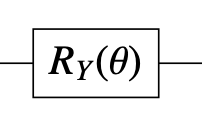

$R_Y(\theta)={\rm e}^{-{\rm i}\frac{\theta}{2}Y}=\begin{pmatrix} \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\ \sin\frac{\theta}{2} & \cos\frac{\theta}{2}\end{pmatrix}$

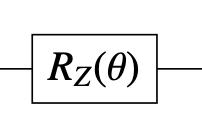

$R_Z(\theta)={\rm e}^{-{\rm i}\frac{\theta}{2}Z}=\begin{pmatrix} e^{-{\rm i}\frac{\theta}{2}} & 0 \\ 0 & e^{{\rm i}\frac{\theta}{2}} \end{pmatrix}$

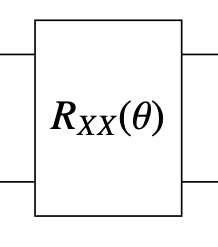

$R_{XX}(\theta)={\rm e}^{-{\rm i}\frac{\theta}{2}XX}=\begin{pmatrix} \cos\frac{\theta}{2} & 0 & 0 & -{\rm i}\sin\frac{\theta}{2} \\ 0 & \cos\frac{\theta}{2} & -{\rm i}\sin\frac{\theta}{2} & 0 \\ 0 & -{\rm i}\sin\frac{\theta}{2} & \cos\frac{\theta}{2} & 0 \\ -{\rm i}\sin\frac{\theta}{2} & 0 & 0 & \cos\frac{\theta}{2}\end{pmatrix}$

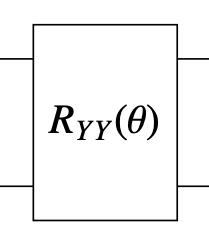

$R_{YY}(\theta)={\rm e}^{-{\rm i}\frac{\theta}{2}YY}=\begin{pmatrix} \cos\frac{\theta}{2} & 0 & 0 & {\rm i}\sin\frac{\theta}{2} \\ 0 & \cos\frac{\theta}{2} & -{\rm i}\sin\frac{\theta}{2} & 0 \\ 0 & -{\rm i}\sin\frac{\theta}{2} & \cos\frac{\theta}{2} & 0 \\ {\rm i}\sin\frac{\theta}{2} & 0 & 0 & \cos\frac{\theta}{2}\end{pmatrix}$

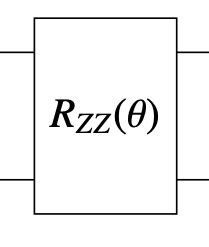

$R_{ZZ}(\theta)={\rm e}^{-{\rm i}\frac{\theta}{2}ZZ}=\begin{pmatrix} e^{-{\rm i}\frac{\theta}{2}} & 0 & 0 & 0 \\ 0 & e^{{\rm i}\frac{\theta}{2}} & 0 & 0 \\ 0 & 0 & e^{{\rm i}\frac{\theta}{2}} & 0 \\ 0 & 0 & 0 & e^{-{\rm i}\frac{\theta}{2}} \end{pmatrix}$

## 量子回路を書いてみる

In [120]:
q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')
qc = QuantumCircuit(q,c)

qc.h(q[0])
qc.measure(q[0], c[0]) 

qc.draw(fold=-1)

┌───┐┌─┐
  q: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

このような量子ゲートと測定の一連の手続きをグラフ化したものを量子回路図という

# 実行する

$<Z>$の計算

### shotをとる

In [121]:
backend = BasicSimulator()

q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')
qc = QuantumCircuit(q,c)

qc.h(q[0])
qc.measure(q[0], c[0]) 

sampler= BackendSampler(backend=backend)
result = sampler.run([(qc)],shots=100).result()[0].data.c.get_counts()
print(result)

{'0': 50, '1': 50}


In [64]:
(1*50-50*1)/100

0.0

In [123]:
q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')
qc = QuantumCircuit(q,c)

qc.h(q[0])
qc.measure(q[0], c[0]) 

sampler= StatevectorSampler()
result = sampler.run([(qc)],shots=100).result()[0].data.c.get_counts()
print(result)

{'1': 51, '0': 49}


### 期待値を直接得る

In [124]:
backend = BasicSimulator()

q = QuantumRegister(1,'q')
qc = QuantumCircuit(q)

qc.h(q[0])

op=[('Z',[0],1.0)]
op=SparsePauliOp.from_sparse_list(op , num_qubits=1)
estimator= BackendEstimator(backend=backend)
result = estimator.run([(qc,op)]).result()[0].data
get=np.array([result.evs,result.stds])
print(get)

[-0.00390625  0.01562488]


In [125]:
q = QuantumRegister(1,'q')
qc = QuantumCircuit(q)
qc.h(q[0])

op=[('Z',[0],1.0)]
op=SparsePauliOp.from_sparse_list(op , num_qubits=1)
estimator= StatevectorEstimator()
result = estimator.run([(qc,op)]).result()[0].data
get=np.array([result.evs,result.stds])
print(get)

[0. 0.]


多量子ビットの場合は測定しないビットについても恒等演算子で埋める必要がある

In [59]:
N=20
q = QuantumRegister(N,'q')
qc = QuantumCircuit(q)
qc.h(q[0])

op=[('Z',[10],1.0)]
op=SparsePauliOp.from_sparse_list(op , num_qubits=N)
print(op)

SparsePauliOp(['IIIIIIIIIZIIIIIIIIII'],
              coeffs=[1.+0.j])


In [63]:
N=20
q = QuantumRegister(N,'q')
qc = QuantumCircuit(q)
qc.h(q[0])

op=[('ZZ',[10,15],1.0)]
op=SparsePauliOp.from_sparse_list(op , num_qubits=N)
print(op)

SparsePauliOp(['IIIIZIIIIZIIIIIIIIII'],
              coeffs=[1.+0.j])


ハミルトニアンの期待値の計算などに使う

$<X>$の計算

In [126]:
q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')
qc = QuantumCircuit(q,c)

qc.h(q[0])

#測定用の基底の変換
qc.h(q[0])
qc.measure(q[0], c[0]) 

qc.draw(fold=-1)

┌───┐┌───┐┌─┐
  q: ┤ H ├┤ H ├┤M├
     └───┘└───┘└╥┘
c: 1/═══════════╩═
                0

### shotをとる

In [127]:
backend = BasicSimulator()

q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')
qc = QuantumCircuit(q,c)

qc.h(q[0])

#測定用の基底の変換
qc.h(q[0])
qc.measure(q[0], c[0]) 

sampler= BackendSampler(backend=backend)
result = sampler.run([(qc)],shots=100).result()[0].data.c.get_counts()
print(result)

{'0': 100}


In [128]:
q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')
qc = QuantumCircuit(q,c)


qc.h(q[0])

#測定用の基底の変換
qc.h(q[0])
qc.measure(q[0], c[0]) 

sampler= StatevectorSampler()
result = sampler.run([(qc)],shots=100).result()[0].data.c.get_counts()
print(result)

{'0': 100}


### 期待値を直接得る

In [129]:
backend = BasicSimulator()

q = QuantumRegister(1,'q')
qc = QuantumCircuit(q)

qc.h(q[0])

op=[('X',[0],1.0)]
op=SparsePauliOp.from_sparse_list(op , num_qubits=1)
estimator= BackendEstimator(backend=backend)
result = estimator.run([(qc,op)]).result()[0].data
get=np.array([result.evs,result.stds])
print(get)

[1. 0.]


In [130]:
q = QuantumRegister(1,'q')
qc = QuantumCircuit(q)
qc.h(q[0])

op=[('X',[0],1.0)]
op=SparsePauliOp.from_sparse_list(op , num_qubits=1)
estimator= StatevectorEstimator()
result = estimator.run([(qc,op)]).result()[0].data
get=np.array([result.evs,result.stds])
print(get)

[1. 0.]


## 問
以下の回路図の通りに回路を作成し,$Z$の期待値を計算せよ

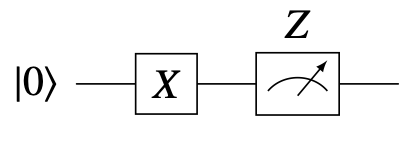

In [131]:
q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')
qc = QuantumCircuit(q,c)

qc.x(q[0])
qc.measure(q[0], c[0]) 

qc.draw(fold=-1)

┌───┐┌─┐
  q: ┤ X ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

In [132]:
backend = BasicSimulator()

q = QuantumRegister(1,'q')
qc = QuantumCircuit(q)

qc.x(q[0])

op=[('Z',[0],1.0)]
op=SparsePauliOp.from_sparse_list(op , num_qubits=1)
estimator= BackendEstimator(backend=backend)
result = estimator.run([(qc,op)]).result()[0].data
get=np.array([result.evs,result.stds])
print(get)

[-1.  0.]


# Bell pair (entanglement state)を作る

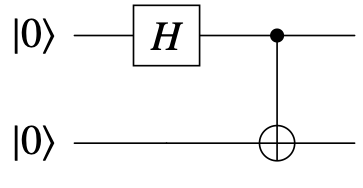

### 問

上記の回路で作られる状態が$|\psi^+\rangle=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$であることを確かめよ

### 問

他のBell状態を作る回路を作成せよ

$ |\psi^-\rangle \equiv\frac{1}{\sqrt{2}}(|00\rangle -|11\rangle ) ,
|\varphi^+\rangle \equiv \frac{1}{\sqrt{2}}(|01\rangle +|10\rangle ) ,
|\varphi^-\rangle \equiv \frac{1}{\sqrt{2}}(|01\rangle -|10\rangle )  $


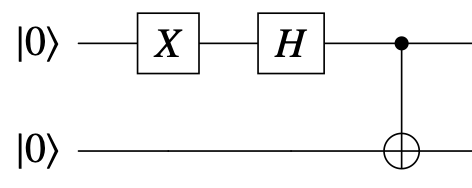

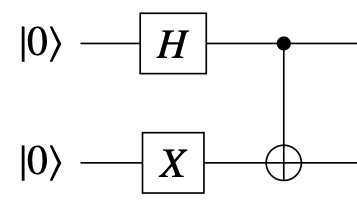

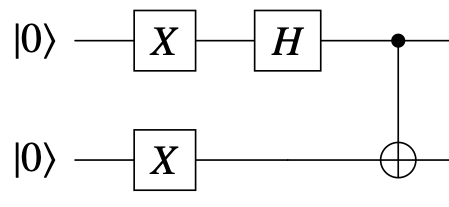

|00\rangle, |01\rangle, |10\rangle, |11\rangleをユニタリ変換(H+CX)して得られるので, $|\psi^+\rangle$, $|\psi^-\rangle$, $|\varphi^+\rangle$, $|\varphi^-\rangle$も完全系を成すことが分かる. これをBell基底という

Bell基底に射影測定したい場合はユニタリ逆変換(CXの後にH)を作用させてからshotをとる

### 問

$ZH=HX$, $HZ=XH$を確認せよ ($H=\frac{Z+X}{\sqrt{2}}$である)

CXとZ,Xの間には次の関係がある

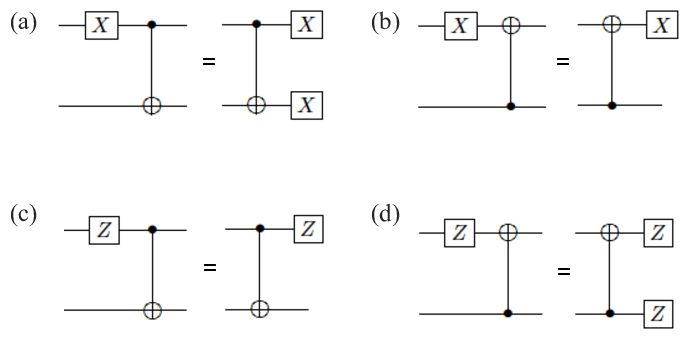

### エンタングルメント状態で一部分のtraceを取ると, 残った部分はmixed stateになることを確かめよう

## Renyi entropyの計算

$|\psi\rangle=\sum_{A,B}\psi_{AB}|AB\rangle$として, $\rho_A={\rm tr}_B|\psi\rangle\langle\psi|$を考える

n次のRenyi entropyは次のように定義される: $S_n(\rho)=\frac{1}{1-n}\log{\rm tr}(\rho_A^n)$

例えば, $n=2$の時は$S_2(\rho)=-\log{\rm tr}(\rho_A^2)$

${\rm tr}(\rho_A^2)$は次のように計算できる:

${\rm tr}(\rho_A^2)=\langle\psi|\otimes\langle\psi|{\rm swap}_A|\psi\rangle\otimes|\psi\rangle$

${\rm swap}_A$は二つの$|\psi\rangle$の間で部分系$A$の計算基底を入れ換える演算子である

$$\langle\psi|\otimes\langle\psi|{\rm swap}_A|\psi\rangle\otimes|\psi\rangle \\
 =\sum_{A_1,B_1}\sum_{A_2,B_2}\sum_{A_3,B_3}\sum_{A_4,B_4}\psi^*_{A_1B_1}\psi^*_{A_2B_2}\psi_{A_3B_3}\psi_{A_4B_4}\langle A_1B_1|\langle A_2B_2|{\rm swap}_A|A_3B_3\rangle|A_4B_4\rangle \\ 
 =\sum_{A_1,B_1}\sum_{A_2,B_2}\sum_{A_3,B_3}\sum_{A_4,B_4}\psi^*_{A_1B_1}\psi^*_{A_2B_2}\psi_{A_3B_3}\psi_{A_4B_4}\langle A_1B_1|\langle A_2B_2|A_4B_3\rangle|A_3B_4\rangle \\
 =\sum_{A_1,B_1}\sum_{A_2,B_2}\psi^*_{A_1B_1}\psi^*_{A_2B_2}\psi_{A_2B_1}\psi_{A_1B_2}
 \\
 =\sum_{A_1}\sum_{A_2}\left(\sum_{B_1}\psi_{A_2B_1}\psi^*_{A_1B_1}\right)\left(\sum_{B_2}\psi_{A_1B_2}\psi^*_{A_2B_2}\right)
  \\
 =\sum_{A_1}\sum_{A_2}[\rho_A]_{A_2A_1}[\rho_A]_{A_1A_2}={\rm tr}\rho_A^2 $$

$|\psi^+\rangle=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$について計算してみよう

$\rho=|\psi^+\rangle\langle\psi^+|=\frac{1}{2}(|00\rangle+|11\rangle)(\langle00|+\langle11|)=\frac{1}{2}(|00\rangle\langle00|+|11\rangle\langle00|+|00\rangle\langle11|+|11\rangle\langle11|)$

$\rho_A=\frac{1}{2}(|0\rangle\langle0|+|1\rangle\langle1|)$より, ${\rm tr}\rho_A^2=2\times\frac{1}{4}=\frac{1}{2}$

$S_2(\rho)=-\log{\rm tr}\rho_A^2=\log2$

## 方法1

Bell pairを作るユニタリゲートを$U$として, $|\psi\rangle=U|00\rangle$とする

$\langle\psi|\otimes\langle\psi|{\rm swap}_A|\psi\rangle\otimes|\psi\rangle=<0000|\left(U^\dagger\otimes U^\dagger{\rm swap}_A U\otimes U |0000\rangle\right)$であることより, $\left(U^\dagger\otimes U^\dagger{\rm swap}_A U\otimes U |0000\rangle\right)$の状態を射影測定し, $|0000\rangle$となる確率を計算する

その確率を$P$とすると$P=({\rm tr}\rho_A^2)^2$である

したがって今の場合$P=\frac{1}{4}=0.25$となるはず

In [133]:
backend = BasicSimulator()

q = QuantumRegister(4,'q')
c = ClassicalRegister(4,'c')
qc = QuantumCircuit(q,c)

qc.h(q[0])
qc.h(q[2])

qc.cx(q[0],q[1])
qc.cx(q[2],q[3])

qc.swap(q[0],q[2])

#Bell pairを作るユニタリゲートの逆を作用させる

qc.cx(q[0],q[1])
qc.cx(q[2],q[3])

qc.h(q[0])
qc.h(q[2])

qc.measure(q, c) 

shots=1000
sampler= BackendSampler(backend=backend)
result = sampler.run([(qc)],shots=shots).result()[0].data.c.get_counts()['0'*4]/shots
print(result)

0.24


### 問

$3$次のRenyi entropyは$\langle\psi|\otimes\langle\psi|\otimes\langle\psi|{\rm swap}_{A_1A_2}{\rm swap}_{A_2A_3}|\psi\rangle\otimes|\psi\rangle\otimes|\psi\rangle$で与えられる

同様にして$|000000\rangle$を測定する確率を計算し, $P=({\rm tr}\rho_A^3)^2=\frac{1}{16}=0.0625$となることを確かめよ

shot数を変えてみて精度を確かめよ

In [134]:
backend = BasicSimulator()

q = QuantumRegister(6,'q')
c = ClassicalRegister(6,'c')
qc = QuantumCircuit(q,c)

qc.h(q[0])
qc.h(q[2])
qc.h(q[4])

qc.cx(q[0],q[1])
qc.cx(q[2],q[3])
qc.cx(q[4],q[5])

qc.swap(q[0],q[2])
qc.swap(q[2],q[4])

#Bell pairを作るユニタリゲートの逆を作用させる

qc.cx(q[0],q[1])
qc.cx(q[2],q[3])
qc.cx(q[4],q[5])

qc.h(q[0])
qc.h(q[2])
qc.h(q[4])

qc.measure(q, c) 

shots=40000
sampler= BackendSampler(backend=backend)
result = sampler.run([(qc)],shots=shots).result()[0].data.c.get_counts()['0'*6]/shots
print(result)

0.061825


場の理論ではSmatrixや時間順序相関関数など$\langle \varphi |U|\psi\rangle$の形の量を計算したいことが多い

これらの量を計算する方法にHadamard testとSwap testと呼ばれる方法がある

## Hadamard test

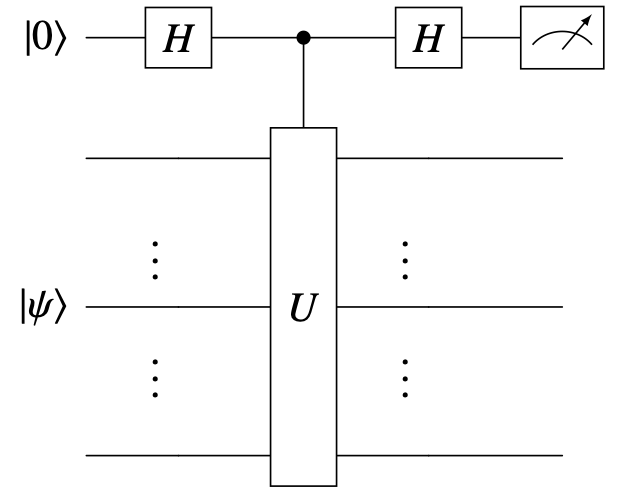

上記の回路で$|0\rangle$を測定する確率$p_+$が$\frac{1}{2}(1+{\rm Re}\left[\langle\psi|U|\psi\rangle\right])$であることを確かめよ

もしくは$X$を測定すると${\rm Re}\left[\langle\psi|U|\psi\rangle\right]$が得られる

Chernoff-Hoeffding 限界

$N$回測定し, $N_+$回$|0\rangle$が得られたとする

$P(\left|\frac{N_+}{N}-p_+\right|>\delta)\leq 2 {\rm e}^{-2N\delta^2} $

$N\sim{\rm poly}(\frac{1}{\delta})$のshot数で誤差$\delta$で$p_+$を推定できる

入力状態が完全混合状態の場合は${\rm Re}\left[{\rm tr}U\right]$の推定を与える

ユニタリ発展を用いて近似的にmixed stateを再現する方法についてはinformation scramblingの項で説明する

計算：

$|0\rangle\otimes|\psi\rangle$

$H\rightarrow\frac{1}{\sqrt{2}}|0\rangle\otimes|\psi\rangle+\frac{1}{\sqrt{2}}|1\rangle\otimes|\psi\rangle$

controlled $U\rightarrow\frac{1}{\sqrt{2}}|0\rangle\otimes|\psi\rangle+\frac{1}{\sqrt{2}}|1\rangle\otimes U|\psi\rangle$

$H\rightarrow\frac{1}{2}\left(|0\rangle+|1\rangle\right)\otimes|\psi\rangle+\frac{1}{2}\left(|0\rangle-|1\rangle\right)\otimes U|\psi\rangle=|0\rangle\otimes\frac{1+U}{2}|\psi\rangle+|1\rangle\otimes\frac{1-U}{2}|\psi\rangle$

$|0\rangle$を測定する確率は${\rm tr}\left[\frac{1+U}{2}|\psi\rangle\langle\psi|\frac{1+U^\dagger}{2}\right]=\frac{1}{2}(1+{\rm Re}\left[\langle\psi|U|\psi\rangle\right])$である

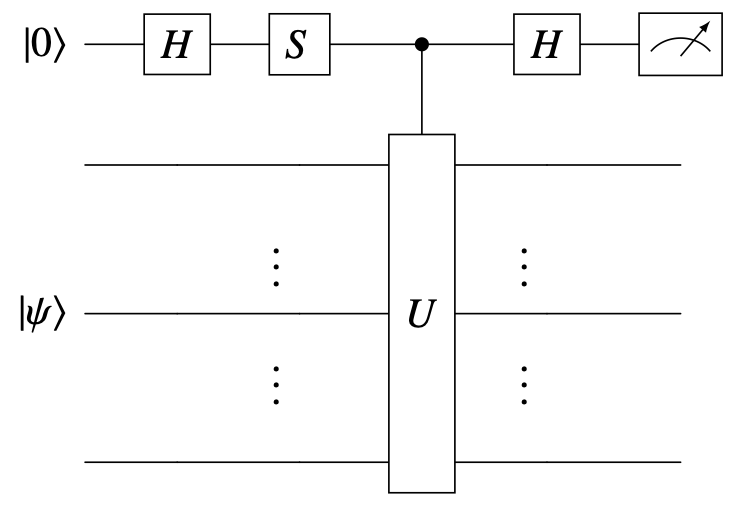

上記の回路で$|0\rangle$を測定する確率が$\frac{1}{2}(1-{\rm Im}\left[\langle\psi|U|\psi\rangle\right])$であることを確かめよ

もしくは$X$を測定すると$-{\rm Im}\left[\langle\psi|U|\psi\rangle\right]$が得られる

計算：

$|0\rangle\otimes|\psi\rangle$

$H\rightarrow\frac{1}{\sqrt{2}}|0\rangle\otimes|\psi\rangle+\frac{1}{\sqrt{2}}|1\rangle\otimes|\psi\rangle$

$S\rightarrow\frac{1}{\sqrt{2}}|0\rangle\otimes|\psi\rangle+\frac{{\rm i}}{\sqrt{2}}|1\rangle\otimes|\psi\rangle$

controlled $U\rightarrow\frac{1}{\sqrt{2}}|0\rangle\otimes|\psi\rangle+\frac{{\rm i}}{\sqrt{2}}|1\rangle\otimes U|\psi\rangle$

$H\rightarrow\frac{1}{2}\left(|0\rangle+|1\rangle\right)\otimes|\psi\rangle+\frac{{\rm i}}{2}\left(|0\rangle-|1\rangle\right)\otimes U|\psi\rangle=|0\rangle\otimes\frac{1+{\rm i}U}{2}|\psi\rangle+|1\rangle\otimes\frac{1-{\rm i}U}{2}|\psi\rangle$

$|0\rangle$を測定する確率は${\rm tr}\left[\frac{1+{\rm i}U}{2}|\psi\rangle\langle\psi|\frac{1-{\rm i}U^\dagger}{2}\right]=\frac{1}{2}(1-{\rm Im}\left[\langle\psi|U|\psi\rangle\right])$である

## 方法2
## Bell pairのHadamard test

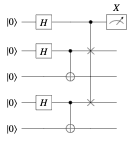

In [147]:
backend = BasicSimulator()

q = QuantumRegister(5,'q')
qc = QuantumCircuit(q)

qc.h(q[0])
qc.h(q[2])
qc.h(q[4])

qc.cx(q[0],q[1])
qc.cx(q[2],q[3])

qc.cswap(q[4],q[0],q[2])

op=[('X',[4],1.0)]
op=SparsePauliOp.from_sparse_list(op , num_qubits=5)
estimator= BackendEstimator(backend=backend)
result = estimator.run([(qc,op)]).result()[0].data
get=np.array([result.evs,result.stds])
print(get)

[0.50927734 0.01344691]


In [136]:
backend = BasicSimulator()

q = QuantumRegister(5,'q')
qc = QuantumCircuit(q)

qc.h(q[0])
qc.h(q[2])
qc.h(q[4])
qc.s(q[4])

qc.cx(q[0],q[1])
qc.cx(q[2],q[3])

qc.cswap(q[4],q[0],q[2])

op=[('X',[4],1.0)]
op=SparsePauliOp.from_sparse_list(op , num_qubits=5)
estimator= BackendEstimator(backend=backend)
result = estimator.run([(qc,op)]).result()[0].data
get=np.array([result.evs,result.stds])
print(get)

[0.00390625 0.01562488]


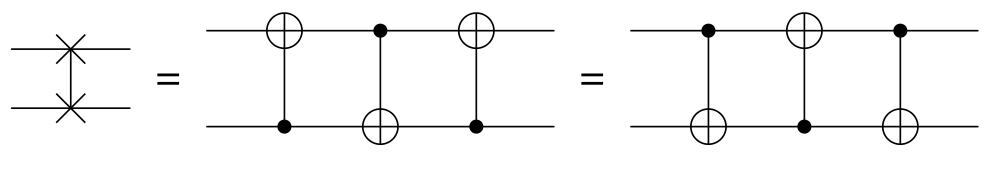

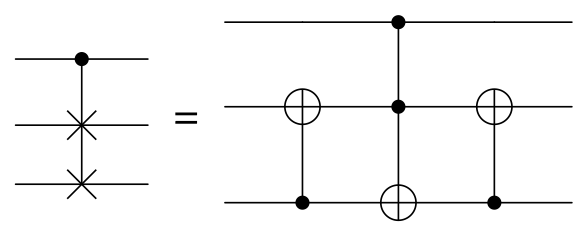

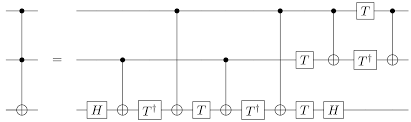

### 問

同じ計算をsamplerを用いて行い, 結果が一致することを確かめよ

In [156]:
backend = BasicSimulator()

q = QuantumRegister(5,'q')
c = ClassicalRegister(1,'c')
qc = QuantumCircuit(q,c)

qc.h(q[0])
qc.h(q[2])
qc.h(q[4])

qc.cx(q[0],q[1])
qc.cx(q[2],q[3])

qc.cswap(q[4],q[0],q[2])

qc.h(q[4])
qc.measure(q[4], c) 

shots=1000
sampler= BackendSampler(backend=backend)

result = sampler.run([(qc)],shots=shots).result()[0].data.c.get_counts()['0']/shots
result = 2*result-1
print(result)

#result = sampler.run([(qc)],shots=shots).result()[0].data.c.get_counts()
#result = (result['0']-result['1'])/shots
#print(result)

0.486


### 問

$3$次のRenyi entropyは$\langle\psi|\otimes\langle\psi|\otimes\langle\psi|{\rm swap}_{A_1A_2}{\rm swap}_{A_2A_3}|\psi\rangle\otimes|\psi\rangle\otimes|\psi\rangle$で与えられる

同様にしてHadamard testを用いて$3$次のRenyi entropyを計算せよ

In [138]:
backend = BasicSimulator()

q = QuantumRegister(7,'q')
qc = QuantumCircuit(q)

qc.h(q[0])
qc.h(q[2])
qc.h(q[4])
qc.h(q[6])

qc.cx(q[0],q[1])
qc.cx(q[2],q[3])
qc.cx(q[4],q[5])

qc.cswap(q[6],q[0],q[2])
qc.cswap(q[6],q[2],q[4])

op=[('X',[6],1.0)]
op=SparsePauliOp.from_sparse_list(op , num_qubits=7)
estimator= BackendEstimator(backend=backend)
result = estimator.run([(qc,op)]).result()[0].data
get=np.array([result.evs,result.stds])
print(get)

[0.23779297 0.01517681]


# CHSH不等式の検証

CHSH不等式：$| \langle BA\rangle - \langle B'A\rangle + \langle BA'\rangle + \langle B'A'\rangle | \leq 2$

### 問

上記の不等式の導出を確かめよ

CHSH不等式：$| \langle BA\rangle - \langle B'A\rangle + \langle BA'\rangle + \langle B'A'\rangle | \leq 2$をQiskitを用いて検証する

Qiskitでは量子ビットの順番は「右から左」である

例えば：演算子 $XZ$ は0番目の量子ビットに$Z$, 1番目の量子ビットに$X$演算子を作用させるという意味になる

$A=Z,~B=Z,~A'=X,~B'=X$とする

In [23]:
obs1 = SparsePauliOp('ZZ') # Z_1Z_0に対応する
obs2 = SparsePauliOp('XZ')
obs3 = SparsePauliOp('ZX')
obs4 = SparsePauliOp('XX')
obs = obs1 - obs2 + obs3 + obs4


In [35]:
from qiskit.circuit import Parameter

theta = Parameter("$\\theta$")

chsh = QuantumCircuit(2)
chsh.h(0)
chsh.cx(0, 1)
chsh.ry(theta, 0) 

In [36]:
number_of_phases = 51
phases = np.linspace(0, 2 * np.pi, number_of_phases)
individual_phases = [[ph] for ph in phases]

In [39]:
backend = BasicSimulator()

estimator= BackendEstimator(backend=backend)
result = estimator.run([(chsh,obs,individual_phases,)]).result()[0].data
evs,std=result.evs,result.stds

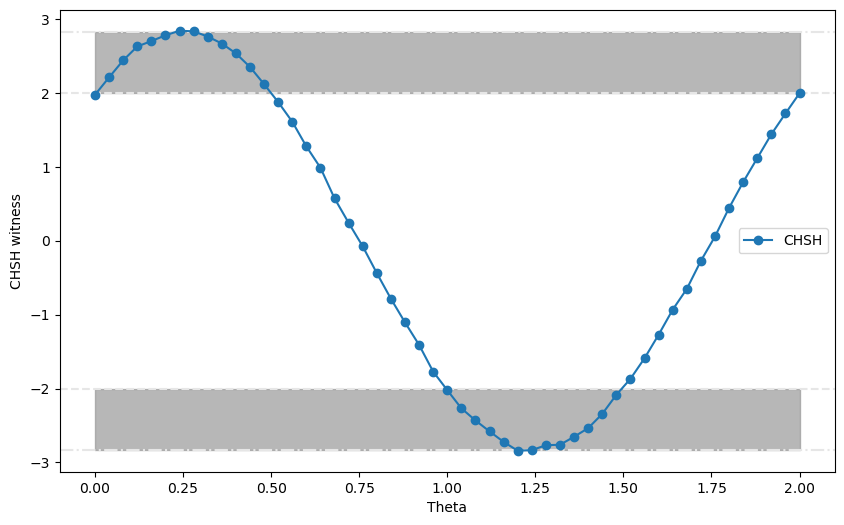

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, evs, "o-", label="CHSH", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

### 問　他のBell状態に変えてCHSH不等式を検証せよ

In [49]:
obs1 = SparsePauliOp('ZZ') # Z_1Z_0に対応する
obs2 = SparsePauliOp('XZ')
obs3 = SparsePauliOp('ZX')
obs4 = SparsePauliOp('XX')
obs = obs1 - obs2 + obs3 + obs4

from qiskit.circuit import Parameter

theta = Parameter("$\\theta$")

chsh = QuantumCircuit(2)
chsh.x(0)
chsh.h(0)
chsh.x(1)
chsh.cx(0, 1)
chsh.ry(theta, 0) 

number_of_phases = 51
phases = np.linspace(0, 2 * np.pi, number_of_phases)
individual_phases = [[ph] for ph in phases]

backend = BasicSimulator()

estimator= BackendEstimator(backend=backend)
result = estimator.run([(chsh,obs,individual_phases,)]).result()[0].data
evs,std=result.evs,result.stds



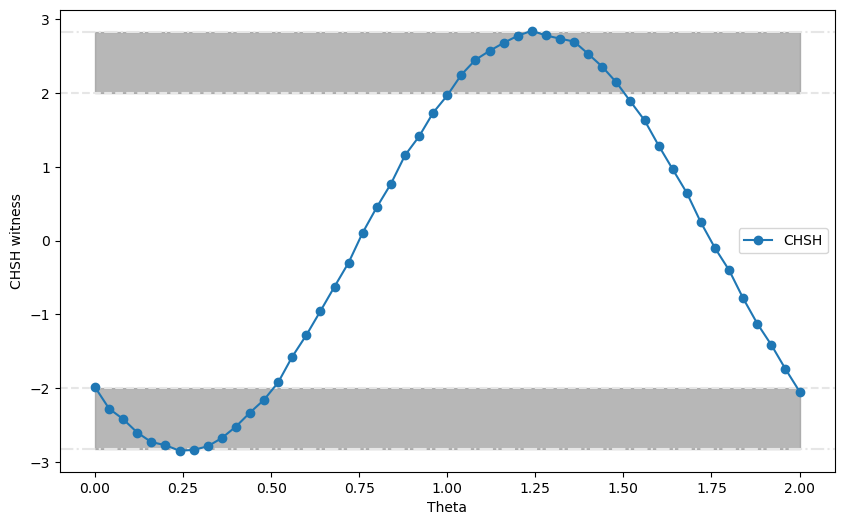

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, evs, "o-", label="CHSH", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

# 量子テレポーテーション

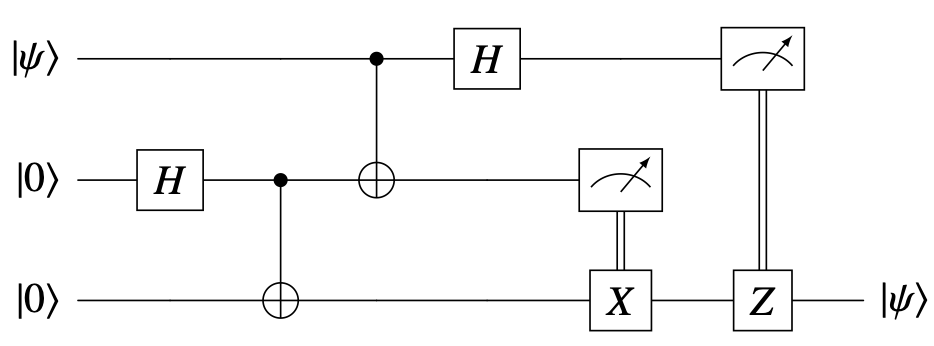

### 上記の回路で作られる状態を順を追って確かめよう

$|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$とする

全系を$|\Psi\rangleと書こう

初期状態は$|\Psi\rangle=|\psi\rangle\otimes|0\rangle\otimes|0\rangle$である

$H(2)\rightarrow|\Psi\rangle=\frac{1}{\sqrt{2}}|\psi\rangle\otimes|0\rangle\otimes|0\rangle+\frac{1}{\sqrt{2}}|\psi\rangle\otimes|1\rangle\otimes|0\rangle$

CX(2,3) $\rightarrow|\Psi\rangle=\frac{1}{\sqrt{2}}|\psi\rangle\otimes|0\rangle\otimes|0\rangle+\frac{1}{\sqrt{2}}|\psi\rangle\otimes|1\rangle\otimes|1\rangle=|\psi\rangle\otimes|\psi^+\rangle$

$=\frac{\alpha}{\sqrt{2}}|0\rangle\otimes|0\rangle\otimes|0\rangle+\frac{\beta}{\sqrt{2}}|1\rangle\otimes|0\rangle\otimes|0\rangle+\frac{\alpha}{\sqrt{2}}|0\rangle\otimes|1\rangle\otimes|1\rangle+\frac{\beta}{\sqrt{2}}|1\rangle\otimes|1\rangle\otimes|1\rangle$

qubit1,2のペアをBell基底で測定することになるので, Bell基底を用いて状態を書き直そう

計算基底をBell基底で展開すると次のようになる:

$|0\rangle\otimes|0\rangle=\frac{1}{\sqrt{2}}\left(|\psi^+\rangle+|\psi^-\rangle\right)$

$|0\rangle\otimes|1\rangle=\frac{1}{\sqrt{2}}\left(|\varphi^+\rangle+|\varphi^-\rangle\right)$

$|1\rangle\otimes|0\rangle=\frac{1}{\sqrt{2}}\left(|\varphi^+\rangle-|\varphi^-\rangle\right)$

$|1\rangle\otimes|1\rangle=\frac{1}{\sqrt{2}}\left(|\psi^+\rangle-|\psi^-\rangle\right)$

これを使うと

$|\Psi\rangle=\frac{\alpha}{\sqrt{2}}\frac{1}{\sqrt{2}}\left(|\psi^+\rangle+|\psi^-\rangle\right)\otimes|0\rangle+\frac{\beta}{\sqrt{2}}\frac{1}{\sqrt{2}}\left(|\varphi^+\rangle-|\varphi^-\rangle\right)\otimes|0\rangle+\frac{\alpha}{\sqrt{2}}\frac{1}{\sqrt{2}}\left(|\varphi^+\rangle+|\varphi^-\rangle\right)\otimes|1\rangle+\frac{\beta}{\sqrt{2}}\frac{1}{\sqrt{2}}\left(|\psi^+\rangle-|\psi^-\rangle\right)\otimes|1\rangle$

$\hspace{1.5em}=\frac{1}{2}|\psi^+\rangle\left(\alpha|0\rangle+\beta|1\rangle\right)+\frac{1}{2}|\psi^-\rangle\left(\alpha|0\rangle-\beta|1\rangle\right)+\frac{1}{2}|\varphi^+\rangle\left(\beta|0\rangle+\alpha|1\rangle\right)+\frac{1}{2}|\varphi^-\rangle\left(-\beta|0\rangle+\alpha|1\rangle\right)$

Bell基底での測定の結果は$|\psi^{+}\rangle$, $|\psi^{-}\rangle$, $|\varphi^{+}\rangle$, $|\varphi^{-}\rangle$のいずれかに$\frac{1}{4}$の確率で射影される

$|\psi^{+}\rangle$に射影された場合 (測定値が00の場合):

射影測定後のqubit3の状態は$|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$となる. (何もしなくて良い)

$|\psi^{-}\rangle$に射影された場合  (測定値が10の場合):

射影測定後のqubit3の状態は$|\psi_{\rm out}\rangle=\alpha|0\rangle-\beta|1\rangle$となる. 

$|\psi\rangle=Z|\psi_{\rm out}\rangle$とすることで, $|\psi\rangle$をqubit3に転送できる

$|\varphi^{+}\rangle$に射影された場合  (測定値が01の場合):

射影測定後のqubit3の状態は$|\psi_{\rm out}\rangle=\beta|0\rangle+\alpha|1\rangle$となる. 

$|\psi\rangle=X|\psi_{\rm out}\rangle$とすることで, $|\psi\rangle$をqubit3に転送できる

$|\varphi^{-}\rangle$に射影された場合  (測定値が01の場合):

射影測定後のqubit3の状態は$|\psi_{\rm out}\rangle=-\beta|0\rangle+\alpha|1\rangle$となる. 

$|\psi\rangle=ZX|\psi_{\rm out}\rangle$とすることで, $|\psi\rangle$をqubit3に転送できる

まとめるとBell基底で測定後, qubit2が$|1\rangle$であればqubit3に$X$を作用させ, その後qubit1が$|1\rangle$でqubit3に$Z$を作用させれば100%の確率でqubit3に$|\psi\rangle$を転送することができる


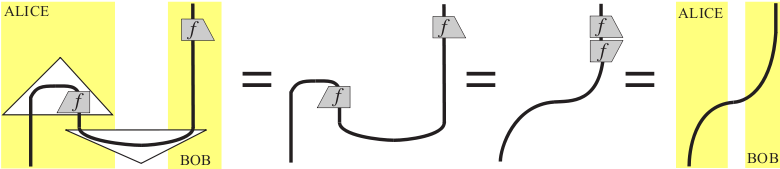

wikipeidaより

### qubit1と3がエンタングルメント状態(Bell pair)にあることを確認してみよう

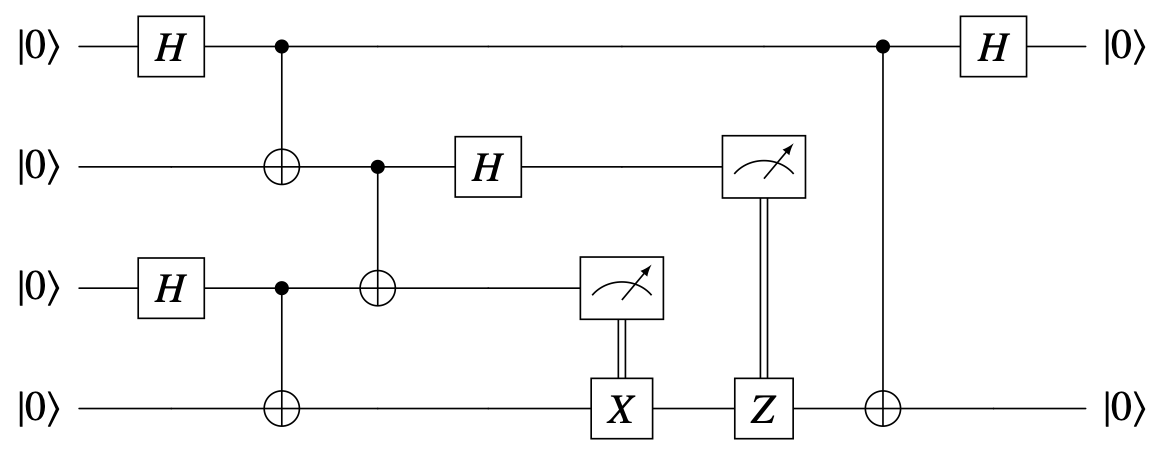

In [21]:
shots=1000
backend = BasicSimulator()

q = QuantumRegister(4,"q")
c = ClassicalRegister(4,'c')
qc = QuantumCircuit(q,c)

# Prepare an entangled state

qc.h(q[0])
qc.cx(q[0], q[1])

qc.h(q[2])
qc.cx(q[2], q[3])

# Bell measurement

qc.cx(q[1], q[2])
qc.h(q[1])

qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

qc.x(q[3]).c_if(c[2], 1)
qc.z(q[3]).c_if(c[1], 1)

qc.cx(q[0], q[3])
qc.h(q[0])

qc.measure(q[0], c[0])
qc.measure(q[3], c[3])

sampler= BackendSampler(backend=backend)
result=sampler.run([(qc)],shots=shots).result()[0].data.c.get_counts()
print(result)

{'0010': 268, '0110': 243, '0100': 257, '0000': 232}


qubit1と4は00の状態のみが観測される

HaydenとPreskillによるBHの情報喪失問題の思考実験はこの問題を量子多体系へ拡張してものとして理解することができる

scrambling circuit = 量子テレポーテーションが高い確率で成功する量子回路

その他の練習問題については以下を参照:
https://github.com/Qiskit/textbook/tree/main/notebooks/ch-algorithms